## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

## Loading Dataset

In [2]:
transform = transforms.ToTensor()

In [3]:
train_data = datasets.FashionMNIST(root="data", train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root="data", train=False, download=True, transform=transform)

100%|██████████| 26.4M/26.4M [00:12<00:00, 2.05MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 199kB/s]
100%|██████████| 4.42M/4.42M [00:02<00:00, 1.50MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 5.17MB/s]


In [4]:
train_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
test_data

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [6]:
class_names = [
    'T-shirt', 'Trouser', 'Sweater', 'Dress', 'Coat', 
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Boot',
]

## Creating Data Loader

In [7]:
train_loader = DataLoader(
    train_data,
    batch_size=10,
    shuffle=True
)

test_loader = DataLoader(
    test_data,
    batch_size=10,
    shuffle=False
)

## Examine Batch of Images

In [8]:
for images, labels in train_loader:
    break

In [9]:
images.shape

torch.Size([10, 1, 28, 28])

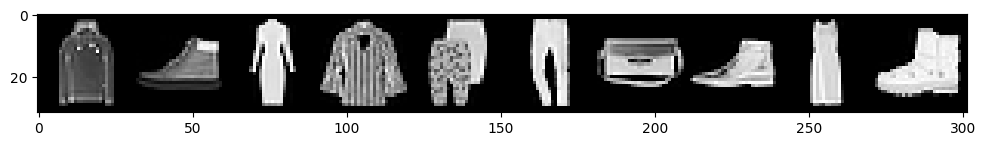

In [12]:
im = make_grid(images, nrow=10)
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im.numpy(), (1,2,0)))

## Creating Model

In [13]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(in_features=5*5*16, out_features=100)
        self.fc2 = nn.Linear(in_features=100, out_features=10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(input=X, kernel_size=2, stride=2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(input=X, kernel_size=2, stride=2)
        X = X.view(-1, 16*5*5)
        X = F.relu(self.fc1(X))
        X = self.fc2(X)
        return F.log_softmax(X, dim=1)

In [14]:
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

In [15]:
parameter_list = []
for param in model.parameters():
    parameter_list.append(param.numel())

print(f"Total Number of Parameters: {sum(parameter_list)}")

Total Number of Parameters: 42050


## Training the Model

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
import time
start_time = time.time()

epochs = 5
train_losses_list = []
test_losses_list = []
train_correct_list = []
test_correct_list = []

for i in range(epochs):
    train_correct = 0
    test_correct = 0

    for batch, (X_train, y_train) in enumerate(train_loader):
        batch += 1
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred.data, 1)[1]
        batch_correct = (predicted == y_train).sum()
        train_correct += batch_correct

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 600 == 0:
            print(f"EPOCH: {i} BATCH: {batch} LOSS: {loss.item()}")

    train_losses_list.append(loss.detach().numpy())
    train_correct_list.append(train_correct)

    # Testing
    with torch.no_grad():
        for batch, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1]
            test_correct += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses_list.append(loss.detach().numpy())
    test_correct_list.append(test_correct)


current_time = time.time()
total_time = current_time - start_time
print(f"Training Took {total_time/60} minutes")

EPOCH: 0 BATCH: 600 LOSS: 0.7242401242256165
EPOCH: 0 BATCH: 1200 LOSS: 0.5027915835380554
EPOCH: 0 BATCH: 1800 LOSS: 0.695161759853363
EPOCH: 0 BATCH: 2400 LOSS: 0.4774913787841797
EPOCH: 0 BATCH: 3000 LOSS: 0.3851134181022644
EPOCH: 0 BATCH: 3600 LOSS: 0.38663333654403687
EPOCH: 0 BATCH: 4200 LOSS: 0.4969189167022705
EPOCH: 0 BATCH: 4800 LOSS: 0.3166221082210541
EPOCH: 0 BATCH: 5400 LOSS: 0.6828473210334778
EPOCH: 0 BATCH: 6000 LOSS: 0.7219887971878052
EPOCH: 1 BATCH: 600 LOSS: 0.11185643821954727
EPOCH: 1 BATCH: 1200 LOSS: 0.21721215546131134
EPOCH: 1 BATCH: 1800 LOSS: 0.1902897208929062
EPOCH: 1 BATCH: 2400 LOSS: 0.1517637073993683
EPOCH: 1 BATCH: 3000 LOSS: 0.2729286849498749
EPOCH: 1 BATCH: 3600 LOSS: 0.17497900128364563
EPOCH: 1 BATCH: 4200 LOSS: 0.26396939158439636
EPOCH: 1 BATCH: 4800 LOSS: 0.6469908952713013
EPOCH: 1 BATCH: 5400 LOSS: 0.15480396151542664
EPOCH: 1 BATCH: 6000 LOSS: 0.3013279139995575
EPOCH: 2 BATCH: 600 LOSS: 0.48522472381591797
EPOCH: 2 BATCH: 1200 LOSS: 0.08

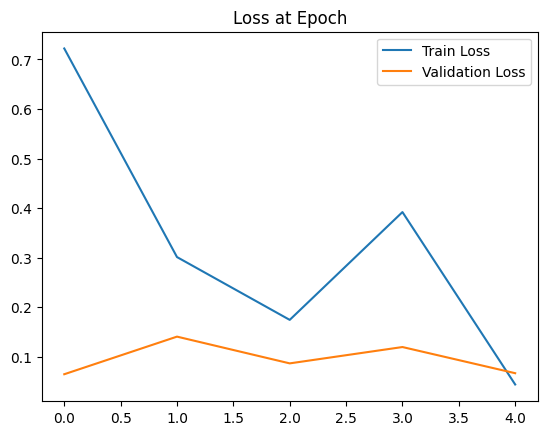

In [18]:
plt.plot(train_losses_list, label='Train Loss')
plt.plot(test_losses_list, label='Validation Loss')
plt.title("Loss at Epoch")
plt.legend();

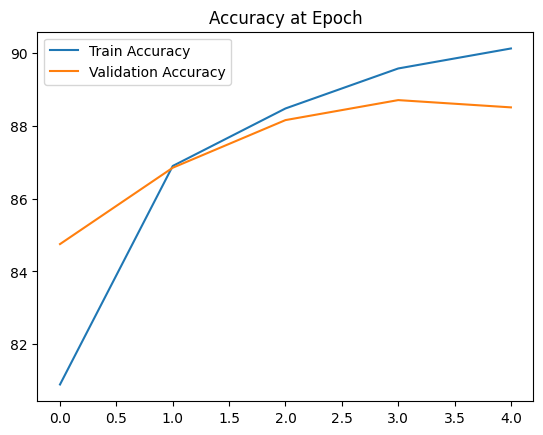

In [19]:
plt.plot([train/600 for train in train_correct_list], label='Train Accuracy')
plt.plot([test/100 for test in test_correct_list], label='Validation Accuracy')
plt.title("Accuracy at Epoch")
plt.legend();

## Evaluate Test Data

In [20]:
test_load_all = DataLoader(
    dataset=test_data,
    batch_size=10000,
    shuffle=False
)

In [21]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val.data, 1)[1]
        correct += (predicted == y_test).sum()

In [22]:
correct.item() / 10000

0.8851

In [23]:
print(classification_report(y_true=predicted.view(-1), y_pred=y_test.view(-1)))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       958
           1       0.97      1.00      0.98       973
           2       0.83      0.83      0.83       999
           3       0.93      0.85      0.89      1093
           4       0.79      0.85      0.82       932
           5       0.92      0.98      0.95       940
           6       0.70      0.67      0.68      1052
           7       0.97      0.90      0.93      1076
           8       0.96      0.98      0.97       978
           9       0.95      0.95      0.95       999

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.88     10000



<Axes: >

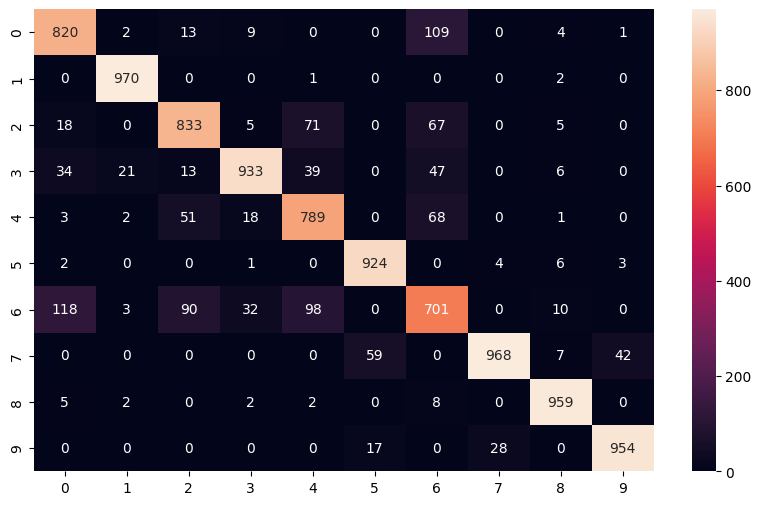

In [24]:
plt.figure(figsize=(10,6))
matrix = confusion_matrix(y_true=predicted.view(-1), y_pred=y_test.view(-1))
sns.heatmap(matrix, annot=True, fmt='1.0f')

## Predicting on Single Image

#### Labels

- 0 T-shirt/top
- 1 Trouser
- 2 Pullover
- 3 Dress
- 4 Coat
- 5 Sandal
- 6 Shirt
- 7 Sneaker
- 8 Bag
- 9 Ankle boot

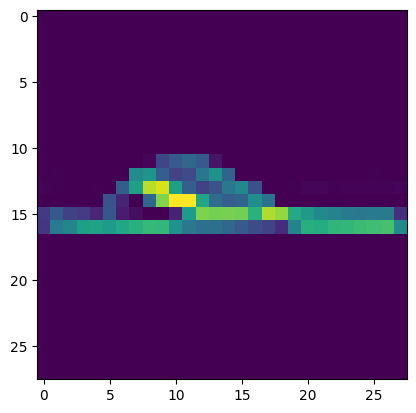

In [39]:
plt.imshow(test_data[7844][0].reshape(28, 28))

In [40]:
model.eval()

with torch.no_grad():
    single_image_prediction = model(test_data[7844][0].view(1, 1, 28, 28))

In [41]:
single_image_prediction.argmax()

tensor(5)